## COMP8420 - Assignment 3 Major Project
#### Quantum Enhanced Text Retrieval Augmented Generation (QRAG)
#### Lucas Hofmockel-Spanakis (45422745)

This notebook serves as a reference implementation and comparison of a novel approach to semantic text retreval.<br>
The core premise is that traditional RAG implementations use linear relationships to represent learned information, however language itself is mathematically non-linear, with the existance and usage of polysemy, compositional semantics, contextual dependencies and many more complicated inter-vocabulary relationships. These linear models use real vector spaces, linear dot product similarities and affine projections.<br>
That's where the theoretical advantage of applying a quantum complex Hilbert Space holds value. By applying the foundations of superposition, entanglement, complex amplitudes and non-commutative operations, we can create word representations that can exist in multiple semantic states, have non-local correlations between distant concepts, and create a data repsresentation that allows word order and context to exist in different states.<br>
These concepts provide our theoretical advantage for representing the non-linear aspects of natural language in a text retrieval system.

Dataset credits in the README of this repo

In [1]:
# Working as of 17/06/25
# On a Linux box running 6.15.2
# Python kernal 3.13.3
# This project is highly dependency sensitive.
# It is recommended to run it in a venv and install requirements.txt

import torch
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# While the linear classic model benefits from gpu offloading,
# our quantum implementation is primarily single threaded on cpu,
# benefitting little from hardware acceleration, regardless of this variable.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

# The RAG implementations
from rag_classic import ClassicalRAG
from rag_quantum import QuantumRAG, QRAGConfig
from rag_random import RandomRAG

# The test runners
from evaluation import RAGEvaluationRunner
from evaluation_lorem import LoremEvaluationTest
from evaluation_academic import AcademicPDFEvaluationTest

from class_training_data_gen import TrainingDataGenerator

Using device: cuda
PyTorch version: 2.7.1+cu126


In [2]:
# These variables control the reproducibility of the results
CONFIG = {
    'classical_embed_dim': 128,
    'lorem_chunks': 1000,
    'chunk_size': 100,
    'retrieval_k': 5,
    'seed': 8420
}

torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
random.seed(CONFIG['seed'])

One of the difficulties with RAG development, is the requirement for the most generalised model possible.<br>
As a result of this requirement, one large training set and multiple different testing sets are used.<br>
This notebook was trained on the dataset found at: https://www.kaggle.com/datasets/manisha717/dataset-of-pdf-files<br>
It totals ~1000 usable pdfs after skipping the corrupted documents.<br>
The documents are split into chunks, and semi-generated query pairs are injected into random chunks.

The generator creates two types of queries for this training set, with two types of data.<br>
We create lorem ipsum magic word injected chunks. This is a relatively accurate test of the models ability to match exact words, using a pretermined list of randomly generated words such as "apple", "emerald" and "elderberry". These words were chosen as they are statistically unlikely to be found in the given contexts of a random chunk in this dataset. The dataset is primarily a collection of old varying government records. Because this dataset is in American english, the generator uses American english as well as to maintain consistant tokenisation and reduce noise. A much larger dataset and larger maximum vocabulary would be able to handle multiple languages, but that is not being tested with this project.<br>
<br>
A simple magic pair would look like:<br>
Chunk: "lorem ipsum the pattern shows elderberry dolor consectetur elit"<br>
Query: "what does the pattern show?"<br>
<br>
It will also generate accurate technical pairings in an attempt to generalise the model for acedemic text retrieval, eg:<br>
The word injceted into this pair is 'normalization'.<br>
Chunk: "normalization optimizes computational efficiency"<br>
Query: "what optimizes computational efficiency?"<br>
<br>
One thing to note about this testing methodology is that it does not mark closely chunk relevant retrevials. A retrieved chunk is either correct or incorrect. While this might lower the usage of it in certain domains, here it provides the strongest criteria for finding the 'correct' information.

In [3]:
# pdfs_train is the folder which contains all the pdfs in the root of it.
# This function will create a pkl file for faster loading on cosecutive runs,
# as the first run on this dataset takes a while.
generator = TrainingDataGenerator("pdfs_train", seed=CONFIG['seed'])
training_data, testing_data, statements_dict = generator.generate_training_corpus(
    num_lorem_chunks=CONFIG['lorem_chunks'], 
    chunk_size=CONFIG['chunk_size']
)

Loading cached training corpus from training_data_generator_seed_8420_lorem_1000_chunk_100.pkl
Loaded cached data:
- Training: 73819 chunks
- Testing: 18455 chunks
- Statements: 150 total (50 per set)


In [4]:
# Trains and returns the results of multiple different quantum rag models
def train_multiple_quantum_configs(configs, training_data, testing_data, training_queries, testing_queries, device='cpu'):
    results = {}
    
    for i, config in enumerate(configs):
        model_name = config.to_string()
        
        print(f"Training {i+1}/{len(configs)}: {model_name}")
        
        quantum_rag = QuantumRAG(config, device)
        quantum_rag.train_from_generator(training_data, testing_data, training_queries, testing_queries)
        
        results[model_name] = {
            'model': quantum_rag,
            'final_loss': quantum_rag.loss_history[-1] if quantum_rag.loss_history else 0,
            'config': config
        }
        print(f"Loss: {quantum_rag.loss_history[-1]:.4f}")
    
    return results

In [5]:
# If you try to train all of these in one go the notebook will likely crash around the end depending on your system
# These parameters were chosen not because the most optimal exists in this config list, but because it provides a
# good starting point to discern any possible patterns in the results.
# name: str, embed_dim: int, num_qubits: int, epochs: int, batch_size: int, learning_rate: float, max_vocab: int
q_configs = [
    QRAGConfig(2, 30, 16, 0.01, 32, 1000, CONFIG['retrieval_k']),
    QRAGConfig(2, 30, 16, 0.01, 64, 1000, CONFIG['retrieval_k']),
    QRAGConfig(2, 30, 16, 0.01, 128, 1000, CONFIG['retrieval_k']),
    QRAGConfig(3, 50, 16, 0.01, 64, 1000, CONFIG['retrieval_k']),
    QRAGConfig(3, 50, 16, 0.01, 64, 2000, CONFIG['retrieval_k']),
    QRAGConfig(4, 30, 16, 0.01, 32, 1000, CONFIG['retrieval_k']),
    QRAGConfig(4, 30, 16, 0.01, 64, 1000, CONFIG['retrieval_k']),
    QRAGConfig(4, 30, 16, 0.01, 128, 1000, CONFIG['retrieval_k']),
    QRAGConfig(6, 30, 16, 0.01, 32, 1000, CONFIG['retrieval_k']),
    QRAGConfig(6, 30, 16, 0.01, 64, 1000, CONFIG['retrieval_k']),
    QRAGConfig(6, 30, 16, 0.01, 128, 1000, CONFIG['retrieval_k']),
    QRAGConfig(8, 30, 16, 0.01, 32, 1000, CONFIG['retrieval_k']),
    QRAGConfig(8, 30, 16, 0.01, 64, 1000, CONFIG['retrieval_k']),
    QRAGConfig(8, 30, 16, 0.01, 128, 1000, CONFIG['retrieval_k']),
    QRAGConfig(8, 30, 16, 0.01, 256, 1000, CONFIG['retrieval_k']),
    QRAGConfig(8, 30, 16, 0.01, 512, 1000, CONFIG['retrieval_k']),
]

# This will create cached models in the root of the project directory to save between multiple runs
quantum_results = train_multiple_quantum_configs(q_configs, training_data, testing_data, statements_dict['training_queries'], statements_dict['testing_queries'], device)

# The training loss of the final epoch for each model
for name, result in quantum_results.items():
    print(f"{name}: {result['final_loss']:.4f}")

Training 1/16: Q2_E30_B16_LR0.01_EB32_MV1000_K5
Quantum RAG initialised: 32D embeddings, 2 qubits on cuda
Training quantum RAG with validation
Quantum embedding: 2 qubits -> 32D
  Quantum layers: 3
  Quantum parameters: 12
  Feature dimension: 8 -> 32
Quantum encoder: 1000 vocab -> 32D via 2 qubits
Trained model loaded from Q2_E30_B16_LR0.01_EB32_MV1000_K5.pkl
Using pre-trained model
Loss: 0.0015
Training 2/16: Q2_E30_B16_LR0.01_EB64_MV1000_K5
Quantum RAG initialised: 64D embeddings, 2 qubits on cuda
Training quantum RAG with validation
Quantum embedding: 2 qubits -> 64D
  Quantum layers: 3
  Quantum parameters: 12
  Feature dimension: 8 -> 64
Quantum encoder: 1000 vocab -> 64D via 2 qubits
Trained model loaded from Q2_E30_B16_LR0.01_EB64_MV1000_K5.pkl
Using pre-trained model
Loss: 0.0005
Training 3/16: Q2_E30_B16_LR0.01_EB128_MV1000_K5
Quantum RAG initialised: 128D embeddings, 2 qubits on cuda
Training quantum RAG with validation
Quantum embedding: 2 qubits -> 128D
  Quantum layers: 3

The input is applied to a classical embedding that is projected to a quantum space of x many qubuts. It then uses a multi-layered parameterised circuit with rotation gates ry and rz, and circular entanglement using CNOT gates. To preserve quantum phase the model extracts both real and imaginary aplitudes as feature extraction, which is finally projected to an embedding space with residual connection to classical output.<br>
<br>
The model uses seperate optimisers with different learning rates and scheduler rates for the classical and quantum components. This is because quantum rotation angles are far more sensitive than classical parameters, as a result quantum loss is highly non-convex with very steep gradients. It also applies contrastive learning, a technique that is standard in RAG development to purposefully seperate irrelevant pairs in vector space. And the final implemented technique is regularisation of the quantum parameters.<br>
<br>
We can see the the quantum influence on the model is around 0.15 to 0.3.
These loss values indicate a definate overtuning.<br>
This is a result of the limited dataset and the limited query context pairs.<br>
These are the final loss values for our tested hyperparameters.<br>
Q2_E30_B16_LR0.01_EB32_MV1000_K5: 0.0015<br>
Q2_E30_B16_LR0.01_EB64_MV1000_K5: 0.0005<br>
Q2_E30_B16_LR0.01_EB128_MV1000_K5: 0.0017<br>
Q3_E50_B16_LR0.01_EB64_MV1000_K5: 0.0001<br>
Q3_E50_B16_LR0.01_EB64_MV2000_K5: 0.0001<br>
Q4_E30_B16_LR0.01_EB32_MV1000_K5: 0.0001<br>
Q4_E30_B16_LR0.01_EB64_MV1000_K5: 0.0013<br>
Q4_E30_B16_LR0.01_EB128_MV1000_K5: 0.0010<br>
Q6_E30_B16_LR0.01_EB32_MV1000_K5: 0.0010<br>
Q6_E30_B16_LR0.01_EB64_MV1000_K5: 0.0002<br>
Q6_E30_B16_LR0.01_EB128_MV1000_K5: 0.0004<br>
Q8_E30_B16_LR0.01_EB32_MV1000_K5: 0.0008<br>
Q8_E30_B16_LR0.01_EB64_MV1000_K5: 0.0001<br>
Q8_E30_B16_LR0.01_EB128_MV1000_K5: 0.0008<br>
Q8_E30_B16_LR0.01_EB256_MV1000_K5: 0.0033<br>
Q8_E30_B16_LR0.01_EB512_MV1000_K5: 0.0011<br>

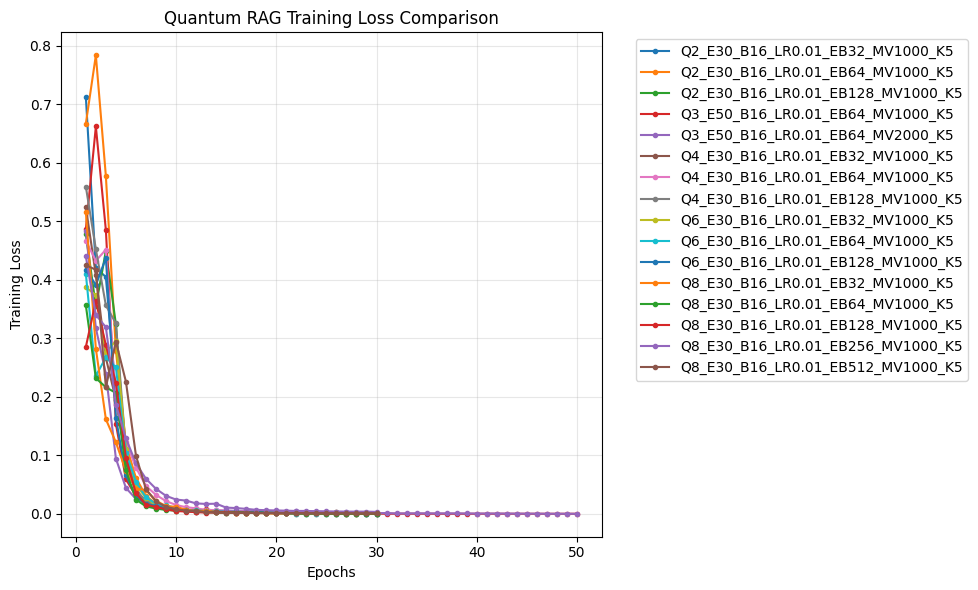

In [6]:
plt.figure(figsize=(10, 6))

for model_name, result in quantum_results.items():
    if result['model'] and hasattr(result['model'], 'loss_history'):
        loss_history = result['model'].loss_history
        epochs = range(1, len(loss_history) + 1)
        plt.plot(epochs, loss_history, label = model_name, marker = 'o', markersize = 3)

plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Quantum RAG Training Loss Comparison')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.grid(True, alpha = 0.3)
plt.tight_layout()
plt.show()

Not every model was trained to 50 epochs, as we can see from the configs most stopped at 30.<br>
While the models themselves vary a lot in hyperparameters, the training loss seems to converge similarly.<br>
With a lowest loss value of 0.0001, this demonstrates severe overtuning. The test results will all be presented below.

In [7]:
# Initialise classical system
# Using 'all-MiniLM-L6-v2' as our comparison point, as it is a very well generalised and widely deployed model.
# It has a base embedding dimension of 384, which gets projected down to the configured value to better compare it to the varying qrag models.
classical_rag = ClassicalRAG(
    embed_dim=CONFIG['classical_embed_dim'], 
    device=device
)

Loading pre-trained sentence transformer
Pre-trained embedding dimension: 384
Classical RAG initialised with pre-trained embeddings on cuda


In [8]:
# This RAG returns chunks at random regardless of the query.
# It serves as a baseline reference point to compare the amount of learning the other models have achieved
random_rag = RandomRAG()

Random RAG initialised. Returns random chunks for any query


The lorem test is the previously described synthetic dataset. Where chunks of context are injected into lorem ipsum text.<br>
Both of the following tests will generate 15 simple and 35 complex query context pairs, which are randomly injected into document chunks.

In [9]:
lorem_test = LoremEvaluationTest(
    evaluation_statements=statements_dict['evaluation_statements'],
    seed=CONFIG['seed']
)

lorem_documents, lorem_queries = lorem_test.generate_evaluation_dataset(
    num_lorem_chunks=CONFIG['lorem_chunks'],
    chunk_size=CONFIG['chunk_size']
)

Lorem Evaluation Test initialised with 50 evaluation statements
Generating lorem ipsum evaluation dataset
- Lorem chunks: 1000
- Evaluation statements to inject: 50
- Chunk size: 100 words
Injected 50 evaluation statements into lorem chunks
Lorem evaluation dataset ready:
- Total documents: 1000
- Documents with injected statements: 50
- Evaluation queries: 50


This test uses academic documents as its base because of their large and often difficult vocabulary usage. Once agin, synthetic query context pairs are injected into chunks of these documents in order to accuratly test the retreval capabilities of the models. The sythetic context injection does contain vocabulary that is relevant to the academic papers providing a difficult test. The reason to use synthetic injection even in this test is to easily be able to track correct and incorrect retrievals.

In [10]:
pdf_test = AcademicPDFEvaluationTest(
        evaluation_statements=statements_dict['evaluation_statements'],
        pdfs_folder="pdfs_academic",
        seed=CONFIG['seed']
    )

pdf_documents, pdf_queries = pdf_test.generate_evaluation_dataset(
    chunk_size=CONFIG['chunk_size'],
    max_chunks_per_pdf=50
)

Academic PDF Evaluation Test initialised:
- PDF folder: pdfs_academic
- Evaluation statements: 50
Generating academic PDF evaluation dataset
- PDF folder: pdfs_academic
- Evaluation statements to inject: 50
- Chunk size: 100 words
- Max chunks per PDF: 50
Processing 25 PDF files
Processing: 84121926.pdf
Extracted 50 chunks (4702 total words)
Processing: 84121956.pdf
Extracted 50 chunks (3378 total words)
Processing: 38026102.pdf
Extracted 50 chunks (6280 total words)
Processing: General-self-similarity--an-overview.pdf
Extracted 50 chunks (3142 total words)
Processing: 11743455.pdf
Extracted 50 chunks (2945 total words)
Processing: 54526939.pdf
Extracted 50 chunks (4172 total words)
Processing: 84042296.pdf
Extracted 50 chunks (6002 total words)
Processing: shors_algorithm.pdf
Extracted 50 chunks (13971 total words)
Processing: 11400830.pdf
Extracted 50 chunks (5151 total words)
Processing: 55806094.pdf
Extracted 50 chunks (11956 total words)
Processing: a-sparse-johnson-lindenstrauss-

Evaluation. Each RAG model will build its own document index for every test, as this is standard practise to apply a pretrained RAG model to a new dataset.<br>
As stated previously, each of  the two tests contains 50 queries, 15 simple and 35 complex. A model is correct if the matching context of a query is retrieved in the top-k results.<br>
The expected results are that the classical model 'all-MiniLM-L6-v2' will perform very well in the lorem ipsum test, possibly well in the simple academic portion, and struggle in the complex academic portion. Meanwhile the QRAG models will likely perform poorly in comparison on the lorem ipsum test, likely due to the generalised patterns leart in training being hard to apply to lorem ipsum. QRAG should in theory perform well in the complex portion of the academic test.

In [11]:
# init evaluators
# these return the result metrics for each model
lorem_evaluator = RAGEvaluationRunner()
pdf_evaluator = RAGEvaluationRunner()

print("Lorem Ipsum Evaluation")
# evaluate baselines on lorem test
lorem_results = {}
lorem_results['Random'] = lorem_evaluator.evaluate_rag_system(
    random_rag, lorem_documents, lorem_queries, "Random RAG", CONFIG['retrieval_k']
)
lorem_results['Classical'] = lorem_evaluator.evaluate_rag_system(
    classical_rag, lorem_documents, lorem_queries, "Classical RAG", CONFIG['retrieval_k']
)

# evaluate all quantum models on lorem test
for model_name, result in quantum_results.items():
    if result['model']:
        lorem_results[model_name] = lorem_evaluator.evaluate_rag_system(
            result['model'], lorem_documents, lorem_queries, model_name, CONFIG['retrieval_k']
        )


print("\nAcademic PDF Evaluation")
# evaluate baselines on academic PDF test
pdf_results = {}
pdf_results['Random'] = pdf_evaluator.evaluate_rag_system(
    random_rag, pdf_documents, pdf_queries, "Random RAG", CONFIG['retrieval_k']
)
pdf_results['Classical'] = pdf_evaluator.evaluate_rag_system(
    classical_rag, pdf_documents, pdf_queries, "Classical RAG", CONFIG['retrieval_k']
)

# evaluate all quantum models on academic PDF test
for model_name, result in quantum_results.items():
    if result['model']:
        pdf_results[model_name] = pdf_evaluator.evaluate_rag_system(
            result['model'], pdf_documents, pdf_queries, model_name, CONFIG['retrieval_k']
        )


print("\nResults")
results_data = []

all_model_names = set(lorem_results.keys()) | set(pdf_results.keys())

for model_name in sorted(all_model_names):
    # get model type and loss
    if model_name in quantum_results and quantum_results[model_name]['model']:
        model_type = "Quantum"
        final_loss = quantum_results[model_name]['final_loss']
    else:
        model_type = "Baseline"
        final_loss = None
    
    # lorem results
    lorem_result = lorem_results[model_name]
    lorem_acc = lorem_result.accuracy
    
    # extract simple/complex breakdown for lorem
    lorem_simple = lorem_result.category_breakdown.get('simple', {}).get('accuracy', 0.0)
    lorem_complex = lorem_result.category_breakdown.get('complex', {}).get('accuracy', 0.0)
    
    # academic PDF results  
    pdf_result = pdf_results[model_name]
    pdf_acc = pdf_result.accuracy
    
    # extract simple/complex breakdown for academic PDF
    pdf_simple = pdf_result.category_breakdown.get('simple', {}).get('accuracy', 0.0)
    pdf_complex = pdf_result.category_breakdown.get('complex', {}).get('accuracy', 0.0)
    
    results_data.append({
        'Model': model_name,
        'Type': model_type,
        'Loss': final_loss,
        'Lorem_Overall': lorem_acc,
        'Lorem_Simple': lorem_simple,
        'Lorem_Complex': lorem_complex,
        'PDF_Overall': pdf_acc,
        'PDF_Simple': pdf_simple,
        'PDF_Complex': pdf_complex,
        'Quantum_Advantage': pdf_acc - lorem_acc
    })

df = pd.DataFrame(results_data)

# percentage columns
percentage_cols = ['Lorem_Overall', 'Lorem_Simple', 'Lorem_Complex', 'PDF_Overall', 'PDF_Simple', 'PDF_Complex', 'Quantum_Advantage']
for col in percentage_cols:
    df[col] = df[col].apply(lambda x: f"{x:.1%}")

# loss column
df['Loss'] = df['Loss'].apply(lambda x: f"{x:.4f}" if x is not None else "N/A")

Lorem Ipsum Evaluation
Evaluating Random RAG...
- Documents: 1000
- Queries: 50
- Retrieval k: 5
Random index built with 2000 chunks
- Index build time: 0.007s
Evaluating Classical RAG...
- Documents: 1000
- Queries: 50
- Retrieval k: 5
Building classical index with pre-trained embeddings
Classical index built with 2000 chunks
- Index build time: 1.295s
Evaluating Q2_E30_B16_LR0.01_EB32_MV1000_K5...
- Documents: 1000
- Queries: 50
- Retrieval k: 5
Building quantum RAG evaluation index
Creating quantum embeddings index
Quantum evaluation index built: 2000 chunks with quantum embeddings
- Index build time: 1.769s
Evaluating Q2_E30_B16_LR0.01_EB64_MV1000_K5...
- Documents: 1000
- Queries: 50
- Retrieval k: 5
Building quantum RAG evaluation index
Creating quantum embeddings index
Quantum evaluation index built: 2000 chunks with quantum embeddings
- Index build time: 1.722s
Evaluating Q2_E30_B16_LR0.01_EB128_MV1000_K5...
- Documents: 1000
- Queries: 50
- Retrieval k: 5
Building quantum RAG 

In [12]:
# display the df
print("Results Summary:")
print("- 50 queries per test: 15 simple + 35 complex")
print("- Quantum_Advantage = PDF_Overall - Lorem_Overall")

display(df)

Results Summary:
- 50 queries per test: 15 simple + 35 complex
- Quantum_Advantage = PDF_Overall - Lorem_Overall


,Model,Type,Loss,Lorem_Overall,Lorem_Simple,Lorem_Complex,PDF_Overall,PDF_Simple,PDF_Complex,Quantum_Advantage
0,Classical,Baseline,nan,82.0%,86.7%,80.0%,14.0%,20.0%,11.4%,-68.0%
1,Q2_E30_B16_LR0.01_EB128_MV1000_K5,Quantum,0.0017,12.0%,0.0%,17.1%,14.0%,13.3%,14.3%,2.0%
2,Q2_E30_B16_LR0.01_EB32_MV1000_K5,Quantum,0.0015,12.0%,33.3%,2.9%,18.0%,33.3%,11.4%,6.0%
3,Q2_E30_B16_LR0.01_EB64_MV1000_K5,Quantum,0.0005,14.0%,6.7%,17.1%,14.0%,20.0%,11.4%,0.0%
4,Q3_E50_B16_LR0.01_EB64_MV1000_K5,Quantum,0.0001,18.0%,13.3%,20.0%,10.0%,20.0%,5.7%,-8.0%
5,Q3_E50_B16_LR0.01_EB64_MV2000_K5,Quantum,0.0001,0.0%,0.0%,0.0%,18.0%,26.7%,14.3%,18.0%
6,Q4_E30_B16_LR0.01_EB128_MV1000_K5,Quantum,0.0010,14.0%,0.0%,20.0%,18.0%,20.0%,17.1%,4.0%
7,Q4_E30_B16_LR0.01_EB32_MV1000_K5,Quantum,0.0001,22.0%,26.7%,20.0%,14.0%,13.3%,14.3%,-8.0%
8,Q4_E30_B16_LR0.01_EB64_MV1000_K5,Quantum,0.0013,16.0%,6.7%,20.0%,18.0%,33.3%,11.4%,2.0%
9,Q6_E30_B16_LR0.01_EB128_MV1000_K5,Quantum,0.0004,16.0%,0.0%,22.9%,12.0%,6.7%,14.3%,-4.0%


For clarification incase the previous writing did not seperate the ideas enough. The training set of pdfs are a different set completely to the academic pdfs used in this testing phase. No training pdfs were used in this domain pdf test, requireing the model to apply generally learned information to a new domain entirely.<br>
The results are mixed but promising.<br>
The baseline comparison model achieved an excellent 82% overall on the lorem ipsum retrieval tests, with the best quantum model lorem result only achieving 28%, being 40% on the simple lorem test, and 22.9% on the complex lorem test. Predictably the grounding random model achieved 0%, which demonstrates correct learning of the quantum model.<br>
In the academic pdf tests, the classical model achieved an overall of 14%, with 20% in the simple magic word task, and only 11.4% on the complex task. This demonstrating the complexity of even the synthetic query context pairs when generated to be contextually difficult and applied to the correct dataset. The best quantum model achieved an overall 18%, with 33% on the simple task, and 11.4% on the complex task. This is however a different model from the best one in the lorem test. And the random model again serving as a baseline, achieving 6.7% on the pdf simple and 0% on the academic pdf complex.<br>
Some of the highlight results are:<br>
- A quantum model achieving 20% on the complex pdf test, nearly twice as much as the classic model result of 40%<br>
- Two quantum models achieving 33.3% on the simple pdf test, nearly 50% more than the 20% results of the classical model<br>
- And a model achieving 40% on the lorem simple test, nearly half the classical result.<br>

We can see that overall the models did not perform incredibly consistantly with their hyperparameters, but patterns do emerge.<br>
Overall the highest achieving quantum models used 64D of embedding for this dataset regardless of qubit amount. Going above the 1000 maximum vocabulary limit did help one model best its otherwise identical comparitive model in the pdf tests. Overall, more quantum models equalled or beat the classical model in the academic pdf test, even with different domain documents for training. This could be because the quantum models were trained on a likely higher percentage of magic word searches, however this idea is not supported by the low lorem ipsum results. The weakness in this project is likely to be the training and testing methodology, as these models gets punished for near results found within other chunks, which is real world application has value. This method of binary grading likely requires the models to be trained on vastly more amounts of data than classical RAG implementations, and this is on top of the already likely larger dataset needed for a quantum model trained in the same way was the classical models.<br>

The purpose of this project was to demonstrate the theoretical benefit of applying quantum circuits to classical linear RAG systems. The quantum advantage and its direct benefits however are difficult to realise as it requires much more training data than classical approaches to deliver on its theoretical performance improvements. The mixed results demonstrate the theoretical benefit as well as the challenges of a quantum semantic system.<br>
Overall these results provide evidence that the quantum advantage can be realised and applied to text RAG models in situations where the complex non-linearity of natural language can be better mapped by the quantum space.